# Introduction to Time Series Forecasting with Statistical Models

## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Forecasting utilities
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

# Keep notebook output clean
import warnings
warnings.filterwarnings("ignore")


## Data Loadin

In [2]:
# Load daily sales data
# Note: update the path if you move this project.
df = pd.read_csv('/home/musa/Desktop/Learn_forcast/data/daily_sales_french_bakery.csv', parse_dates=['ds'])

# Keep only products with at least 4 weeks of data
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)

# Drop price column to focus on demand (y)
df = df.drop(["unit_price"], axis=1)

df.head()


,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


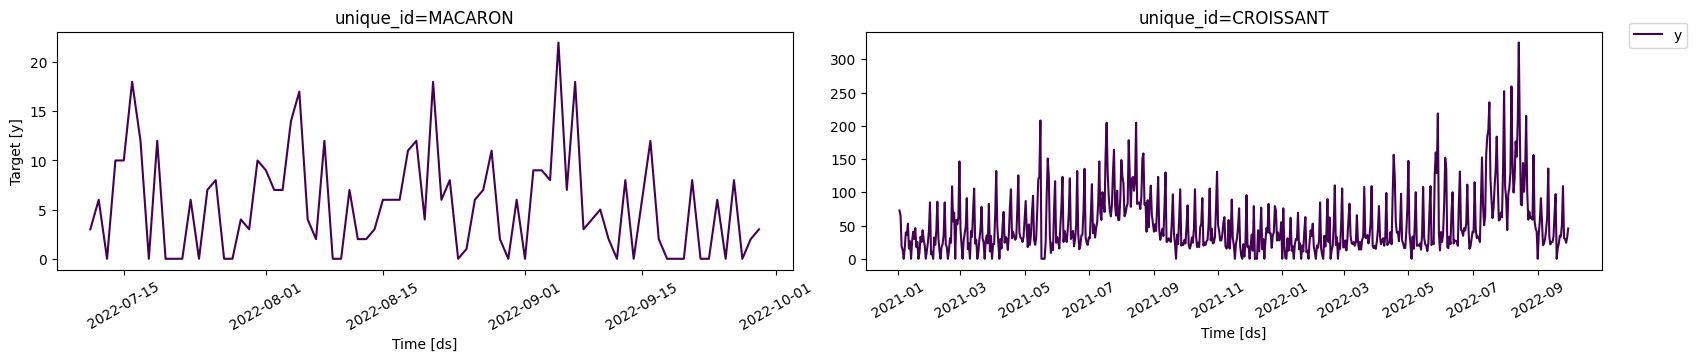

In [3]:
# Compare two products across the full history
plot_series(df=df, ids=["MACARON", "CROISSANT"], palette="viridis")


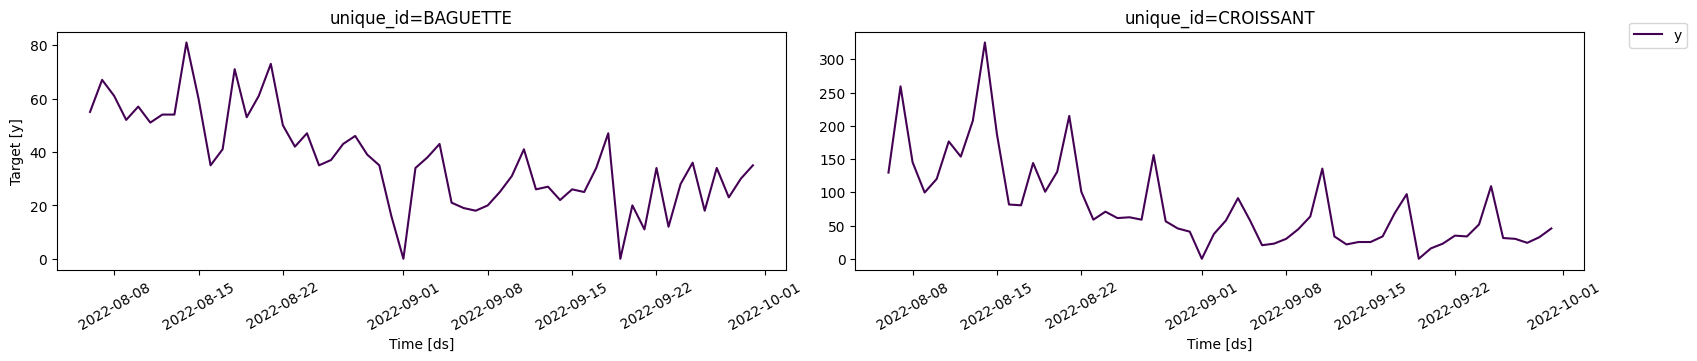

In [4]:
# Zoom into the last 8 weeks to see recent behavior
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")


## Baseline Models

In [5]:
# Simple statistical baselines
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive


In [6]:
# Forecast 7 days ahead
horizon = 7

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=df)
preds = sf.predict(h=horizon)


In [7]:
# Preview forecast output format
preds.head()


,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


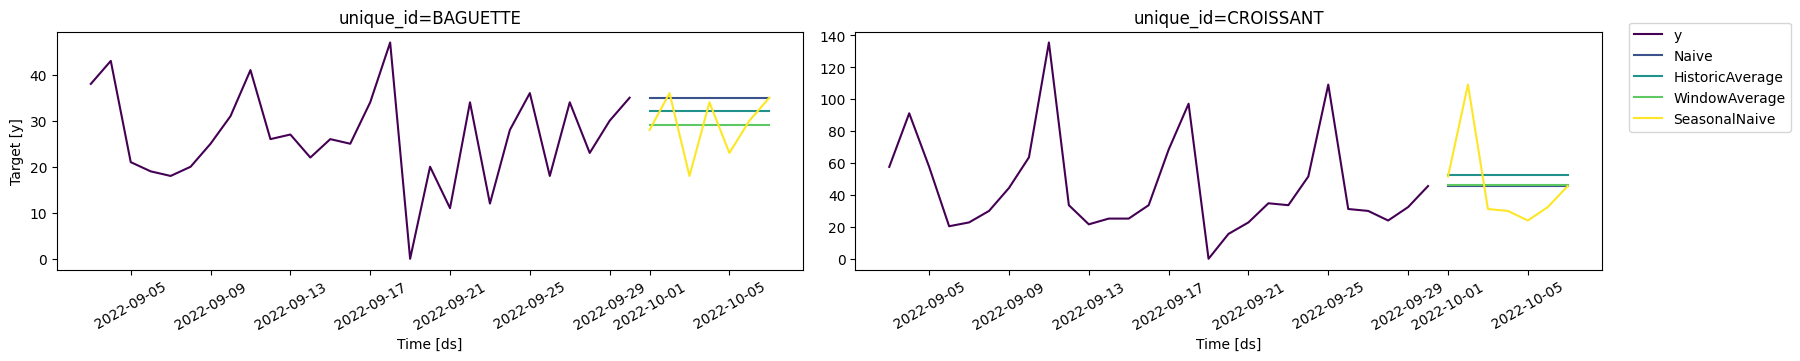

In [8]:
# Plot baseline forecasts alongside history
plot_series(
    df=df, 
    forecasts_df=preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")


## Train/Test Split and Evaluation


In [9]:
# Hold out the last 7 days per product for testing
test = df.groupby('unique_id').tail(7)
train = df.drop(test.index).reset_index(drop=True)


In [10]:
# Refit on training data and align predictions with test set
sf.fit(df=train)

preds = sf.predict(h=horizon)

eval_df = pd.merge(test, preds, 'left', ['ds', "unique_id"])


### Evaluate Baseline Models


In [11]:
# Compute MAE for each method
evaluation = evaluate(
    df=eval_df, 
    metrics=[mae],
)
evaluation.head()


,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [12]:
# Average MAE across products
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation


,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


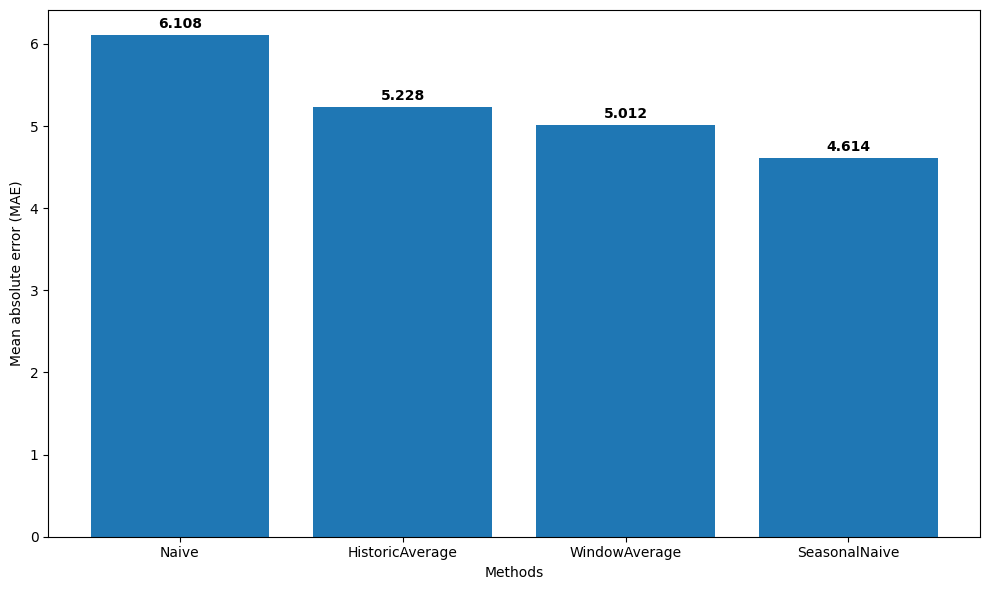

In [13]:
# Visualize baseline errors
methods = evaluation.columns[1:].tolist()  
values = evaluation.iloc[0, 1:].tolist() 

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()


## ARIMA Models (AutoARIMA)

In [14]:
# Automatic ARIMA model selection
from statsforecast.models import AutoARIMA
# Use two example products for faster ARIMA training
unique_ids = ["BAGUETTE", "CROISSANT"]

small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval


,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


In [15]:
# Average MAE across the selected products
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval


,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


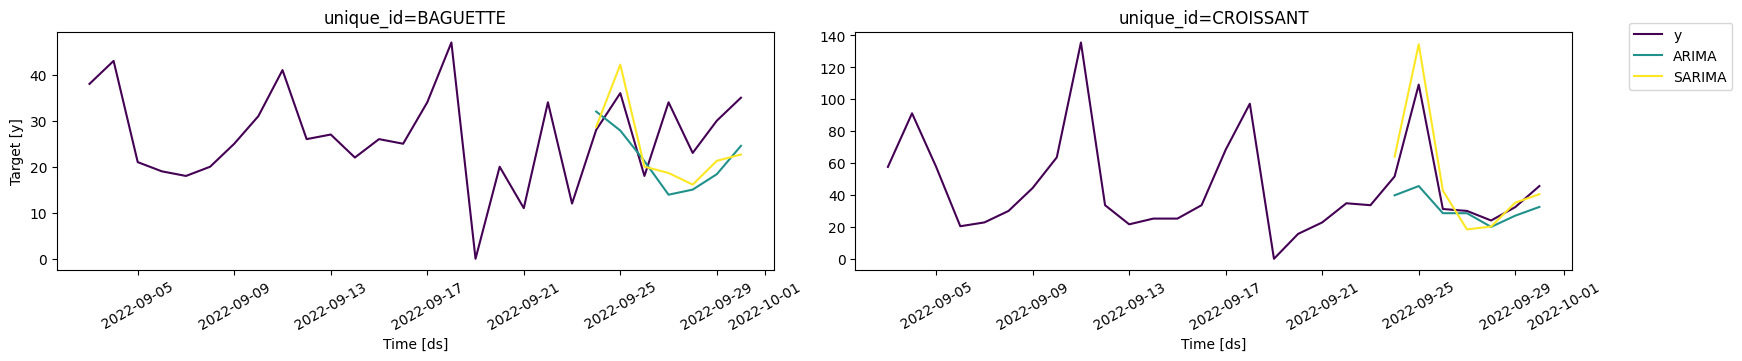

In [16]:
# Plot ARIMA forecasts
plot_series(
    df=df, 
    forecasts_df=arima_preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")


### Why SARIMA Often Wins

SARIMA captures multiple patterns at once:

1. Short-term autocorrelation (recent days matter)
2. Trend (level changes over time)
3. Weekly seasonality (day-of-week effects)

Most simpler baselines miss at least one of these.


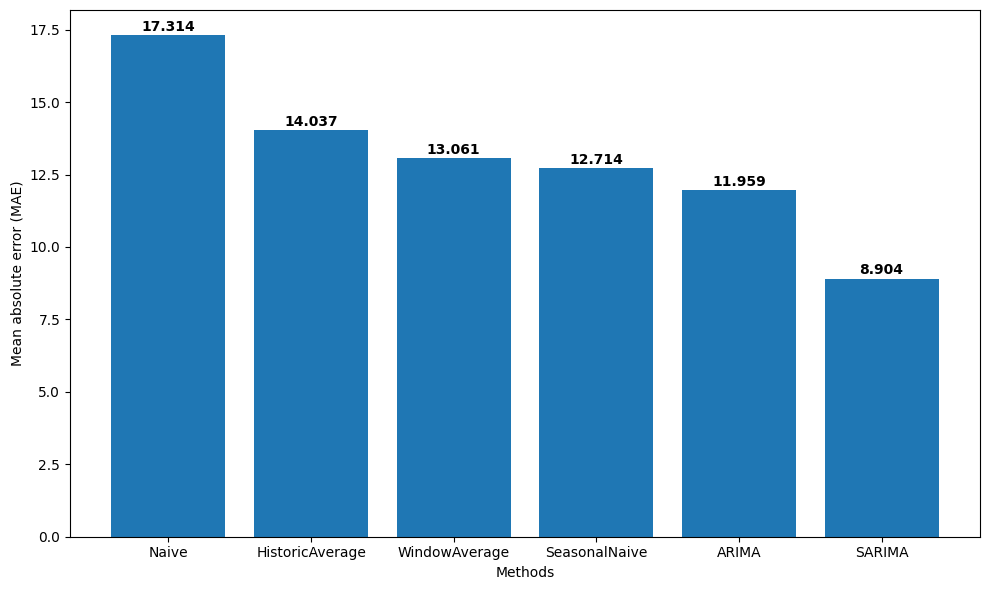

In [17]:
# Compare ARIMA variants by MAE
methods = arima_eval.columns[1:].tolist()  
values = arima_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()


## Rolling Cross-Validation

In [18]:
# Rolling origin evaluation for more robust performance estimates
small_df = df[df["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=7),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
cv_df = sf.cross_validation(
    h=horizon, # 7 days
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_df.head()


,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.355196,71.584713
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.337980,78.458883
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.195004,57.001732
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.649013,49.401144
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.785876,49.725278


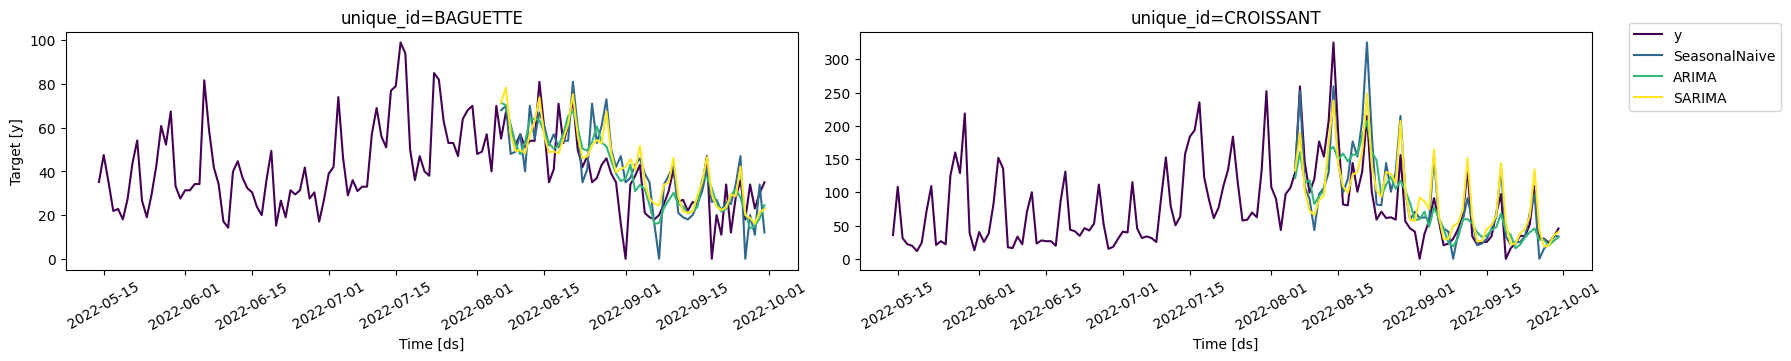

In [19]:
# Visualize rolling forecasts across multiple cutoffs
plot_series(
    df=small_df, 
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1), 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=140, 
    palette="viridis")


In [20]:
# Evaluate MAE across all CV windows
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval


,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.17093,19.281296


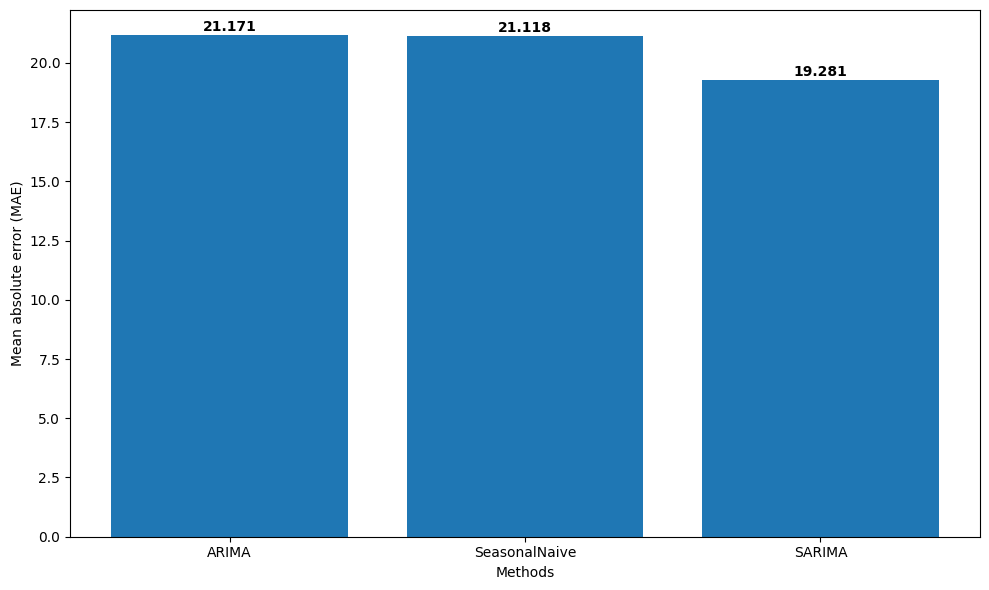

In [21]:
# Compare CV performance by method
methods = cv_eval.columns[1:].tolist()  
values = cv_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()


## Forecasting with exogenous features

In [22]:
df = pd.read_csv("data/daily_sales_french_bakery.csv", parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df.head()

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0


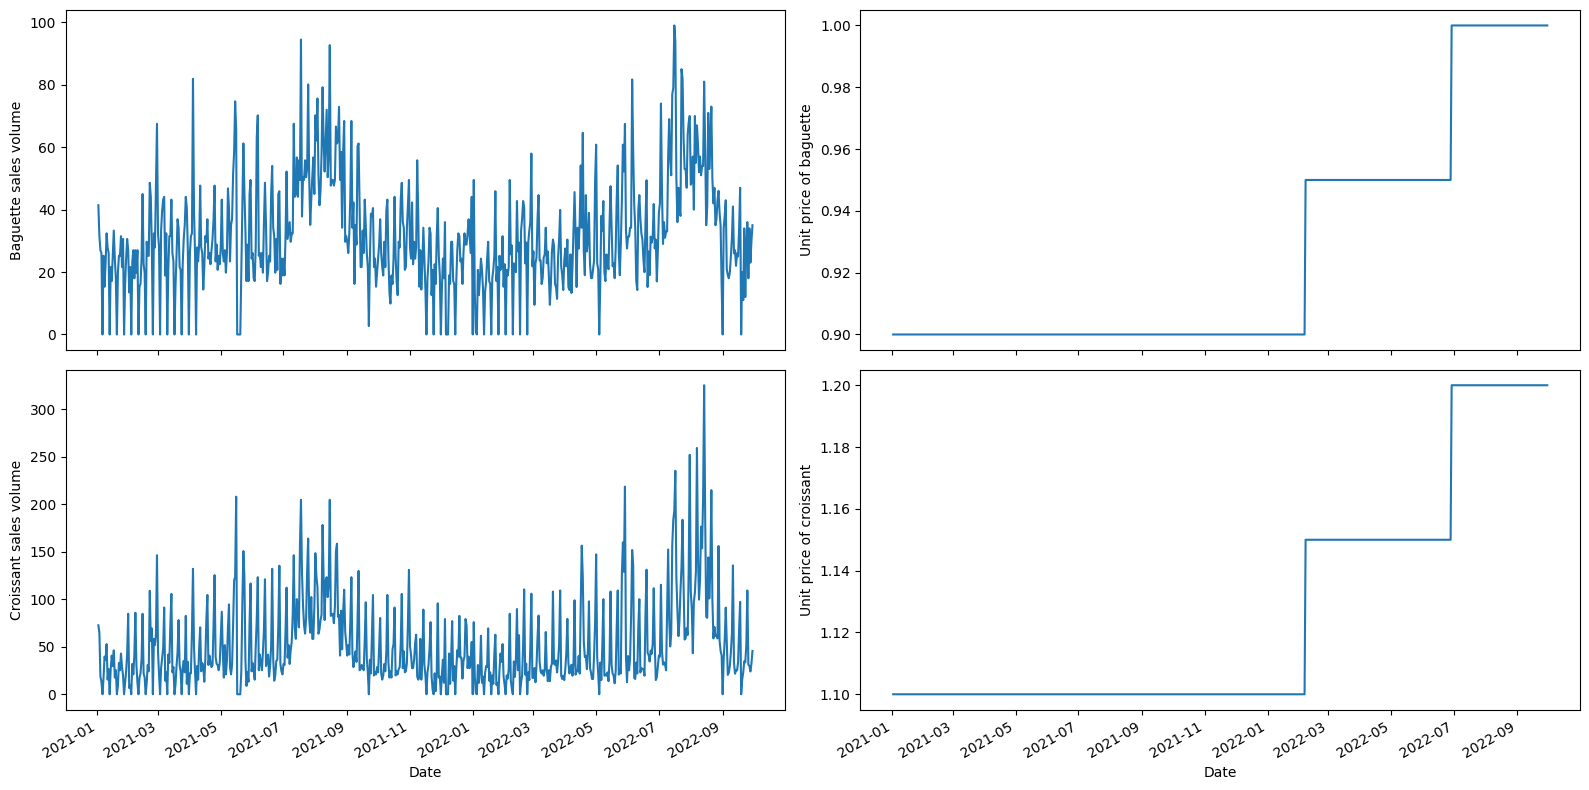

In [23]:
baguette_plot_df = df[df["unique_id"] == "BAGUETTE"]
croissant_plot_df = df[df["unique_id"] == "CROISSANT"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,8))

ax1.plot(baguette_plot_df["ds"], baguette_plot_df["y"])
ax1.set_xlabel("Date")
ax1.set_ylabel("Baguette sales volume")

ax2.plot(baguette_plot_df["ds"], baguette_plot_df["unit_price"])
ax2.set_xlabel("Date")
ax2.set_ylabel("Unit price of baguette")

ax3.plot(croissant_plot_df["ds"], croissant_plot_df["y"])
ax3.set_xlabel("Date")
ax3.set_ylabel("Croissant sales volume")

ax4.plot(croissant_plot_df["ds"], croissant_plot_df["unit_price"])
ax4.set_xlabel("Date")
ax4.set_ylabel("Unit price of croissant")

fig.autofmt_xdate()
plt.tight_layout()

In [26]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_df = df[df["unique_id"].isin(unique_ids)]
test = small_df.groupby("unique_id").tail(7)
train = small_df.drop(test.index).reset_index(drop=True)

In [27]:
futr_exog_df = test.drop(["y"], axis=1)
futr_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [28]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)
arima_exog_preds = sf.predict(h=7, X_df=futr_exog_df)

models = [
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train.drop(["unit_price"], axis=1))
arima_preds = sf.predict(h=horizon)

In [29]:
test_df = test.merge(arima_exog_preds, on=["unique_id", "ds"], how="left")\
              .merge(arima_preds, on=["unique_id", "ds"], how="left")
test_df.head()

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,BAGUETTE,2022-09-24,28.0,1.0,28.898898,28.657114
1,BAGUETTE,2022-09-25,36.0,1.0,42.513264,42.182373
2,BAGUETTE,2022-09-26,18.0,1.0,20.423976,20.013652
3,BAGUETTE,2022-09-27,34.0,1.0,19.066264,18.646490
4,BAGUETTE,2022-09-28,23.0,1.0,16.468885,16.114925


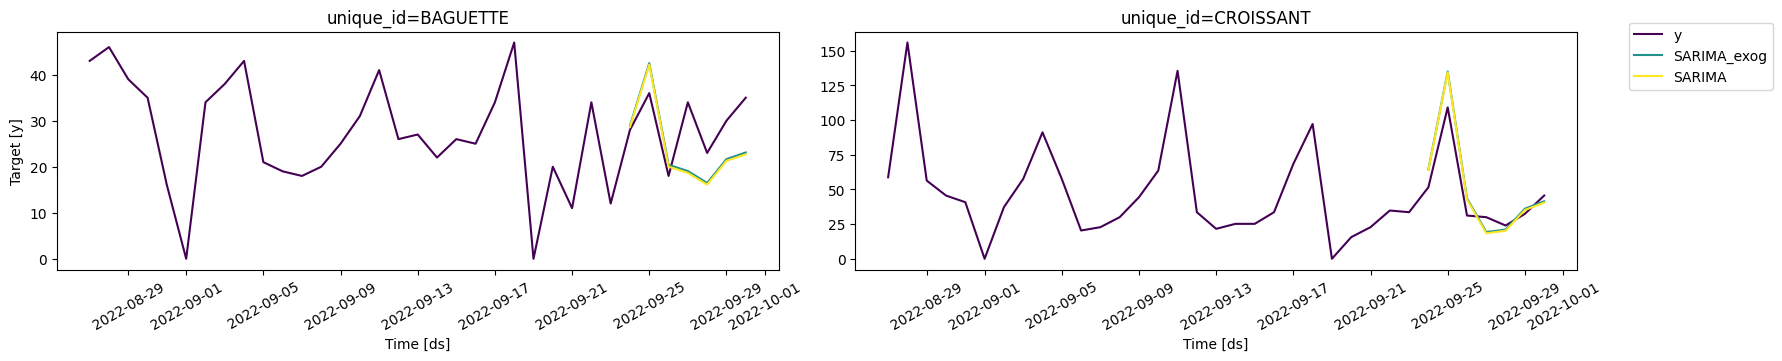

In [30]:
plot_series(
    df=train, 
    forecasts_df=test_df, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28,
    models=["SARIMA_exog", "SARIMA"],
    palette="viridis"
)

In [31]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
cv_exog_df = sf.cross_validation(
    h=horizon, # 7 days
    df=small_df,
    n_windows=8,
    step_size=7,
    refit=True
)

cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683


In [32]:
cv_exog_eval = evaluate(
    cv_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_exog_eval = cv_exog_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_exog_eval

,metric,SARIMA_exog
0,mae,19.211687


### Creating features from timestamps

In [33]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

In [34]:
features = [
    partial(fourier, season_length=7, k=2),
    partial(time_features, features=["day", "week", "month"])
]

small_exog_df, futr_exog_df = pipeline(
    df=small_df,
    features=features,
    freq="D",
    h=horizon
)

In [35]:
small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [36]:
futr_exog_df

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,BAGUETTE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,BAGUETTE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,BAGUETTE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,BAGUETTE,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,BAGUETTE,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10
5,BAGUETTE,2022-10-06,-0.781828,-0.974931,0.623495,-0.222509,6,40,10
6,BAGUETTE,2022-10-07,-0.000009,-0.000017,1.000000,1.000000,7,40,10
7,CROISSANT,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
8,CROISSANT,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
9,CROISSANT,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10


In [38]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_time_exog")
]

sf = StatsForecast(models=models, freq="D")
cv_time_exog_df = sf.cross_validation(
    h=horizon, # 7 days
    df=small_exog_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_time_exog_eval = cv_time_exog_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_time_exog_eval

,metric,SARIMA_time_exog
0,mae,19.721581


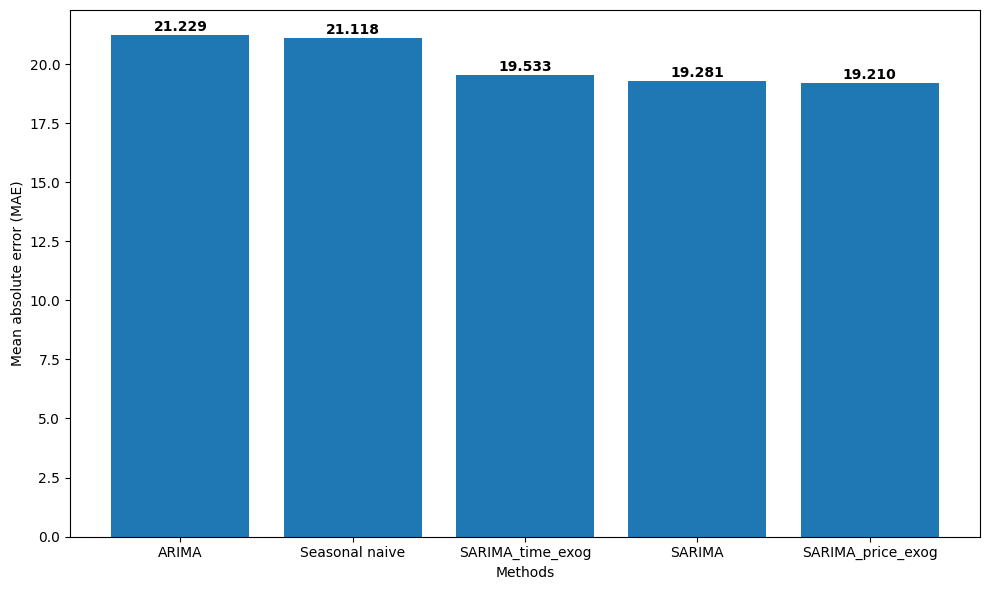

In [39]:
methods = ["ARIMA", "Seasonal naive", "SARIMA", "SARIMA_price_exog", "SARIMA_time_exog"] 
values = [21.229, 21.118, 19.281, 19.210, 19.533]

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()